# A multi layer epithelium

Consisting of stacked 2D sheets

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tyssue
from tyssue.core.sheet import Sheet
from tyssue.geometry.sheet_geometry import SheetGeometry
from tyssue.geometry.planar_geometry import PlanarGeometry
from tyssue.dynamics.sheet_vertex_model import SheetModel
from tyssue.dynamics.planar_vertex_model import PlanarModel

from tyssue.draw.plt_draw import sheet_view
from scipy.interpolate import Rbf
from tyssue.core.generation import hexa_grid2d, from_2d_voronoi
from tyssue.utils.utils import spec_updater
from scipy.spatial import Voronoi
from tyssue.draw.vispy_draw import vp_view

import seaborn as sns


In [2]:
base_specs = tyssue.config.geometry.sheet_spec()



In [3]:
specs = base_specs.copy()
specs['face']['layer'] = 0
specs['vert']['layer'] = 0
specs['vert']['depth'] = 0.0
specs['edge']['layer'] = 0
specs['settings']['geometry'] = 'flat'

In [4]:
layer1_centers = hexa_grid2d(24, 24, 1, 1, 0.4)
layer2_centers = hexa_grid2d(16, 16, 2, 2, 1)
layer1_data = from_2d_voronoi(Voronoi(layer1_centers))
layer2_data = from_2d_voronoi(Voronoi(layer2_centers))
layer2_data['vert']['z'] = 1.

In [34]:


class MultiSheet():
    
    
    def __init__(self, name, layer_datasets, specs):
        
        self.coords = ['x', 'y', 'z']
        self.layers = [Sheet('{}_{}'.format(name, i),
                             dsets, specs,
                             coords=self.coords)
                       for i, dsets in enumerate(layer_datasets)]
        for i, layer in enumerate(self):
            for dset in layer.datasets.values():
                dset['layer'] = i
        self.colors = [color for color in 
                       sns.color_palette("deep", len(self.layers))]
        

    def __iter__(self):
        for layer in self.layers:
            yield layer
    
    def __getitem__(self, n):
        return self.layers[n]
    
    def __len__(self):
        return len(self.layers)
    
    @property
    def Nes(self):
        return [layer.Ne for i, layer in self]
    
    @property
    def Nvs(self):
        return [layer.Nv for i, layer in self]

    @property
    def Nfs(self):
        return [layer.Nf for i, layer in self]

    @property
    def v_idxs(self):
        return np.array([sheet.Nv for sheet
                         in msheet]).cumsum()
    
    @property
    def f_idxs(self):
        return np.array([sheet.Nf for sheet
                         in msheet]).cumsum()
    
    @property
    def e_idxs(self):
        return np.array([sheet.Ne for sheet
                         in msheet]).cumsum() 
    
    def concat_datasets(self):
        datasets = {}
        
        v_dfs = [self[0].vert_df]
        e_dfs = [self[0].edge_df]
        f_dfs = [self[0].face_df]
        
        v_shift = 0
        f_shift = 0
        e_shift = 0
        for lower, upper in zip(self[:-1],
                                self[1:]):
            v_shift += lower.Nv
            v_dfs.append(
                upper.vert_df.set_index(upper.vert_df.index
                                        + v_shift))
            f_shift += lower.Nf
            f_dfs.append(
                upper.face_df.set_index(upper.face_df.index
                                        + f_shift))
            e_shift += lower.Ne
            shifted_edge_df = upper.edge_df.set_index(
                upper.edge_df.index + e_shift)
            shifted_edge_df[['srce', 'trgt']] += v_shift
            shifted_edge_df['face'] += f_shift
            e_dfs.append(shifted_edge_df)
        
        for key, dfs in zip(['edge', 'face', 'vert'],
                            [e_dfs, f_dfs, v_dfs]):
            datasets[key] = pd.concat(dfs)
        return datasets
    
    def update_interpolants(self):
        self.interpolants = [Rbf(sheet.vert_df['x'],
                                 sheet.vert_df['y'],
                                 sheet.vert_df['z'])
                             for sheet in self]
    


In [35]:
msheet = MultiSheet('two',
                    [layer1_data,
                     layer2_data],
                    specs)

In [36]:


class MultiSheetGeometry():
    
    @classmethod
    def update_all(cls, msheet):
        
        msheet.update_interpolants()
        for sheet in msheet:
            SheetGeometry.update_dcoords(sheet)
            SheetGeometry.update_length(sheet)
            SheetGeometry.update_centroid(sheet)
            SheetGeometry.update_normals(sheet)
            SheetGeometry.update_areas(sheet)
            SheetGeometry.update_perimeters(sheet)
            #SheetGeometry.update_vol(sheet)
        cls.update_heights(msheet)
        
    @staticmethod
    def update_heights(msheet):
        
        for lower, upper in zip(msheet.interpolants[:-1], 
                                msheet[1:]):
            upper.vert_df['height'] = (upper.vert_df['z']
                                       - lower(upper.vert_df['x'],
                                               upper.vert_df['y']))
            
        for lower, upper in zip(msheet[:-1], 
                                msheet.interpolants[1:]):
            lower.vert_df['depth'] = (upper(lower.vert_df['x'],
                                            lower.vert_df['y'])
                                      - lower.vert_df['z'])
            

        

In [37]:
MultiSheetGeometry.update_all(msheet)

In [38]:



def msheet_view(msheet, phi, psi, theta, ax=None):
    
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    cos_psi = np.cos(psi)
    sin_psi = np.sin(psi)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    rotation = np.array([[cos_psi*cos_phi - sin_psi*cos_theta*sin_phi,
                          -cos_psi*sin_phi - sin_psi*cos_theta*cos_phi,
                          sin_psi*sin_theta],
                         [sin_psi*cos_phi + cos_psi*cos_theta*sin_phi,
                          -sin_psi*sin_phi + cos_psi*cos_theta*cos_phi,
                          -cos_psi*sin_theta],
                         [sin_theta*sin_phi,
                          sin_theta*cos_phi,
                          cos_theta]])

    draw_specs = tyssue.config.draw.sheet_spec()
    
    draw_specs['vert']['visible'] = False
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
    for sheet, color in zip(msheet, msheet.colors):
        draw_specs['edge']['color'] = color        
        rotated = np.dot(sheet.vert_df[sheet.coords], rotation)
        sheet.vert_df['rx'] = rotated[:, 0]
        sheet.vert_df['ry'] = rotated[:, 1]
        sheet.edge_df['drx'] = (sheet.upcast_trgt(sheet.vert_df['rx'])
                                - sheet.upcast_srce(sheet.vert_df['rx']))
        sheet.edge_df['dry'] = (sheet.upcast_trgt(sheet.vert_df['ry'])
                                - sheet.upcast_srce(sheet.vert_df['ry']))
        
        fig, ax = sheet_view(sheet, coords=['rx', 'ry'], ax=ax, **draw_specs)
    return fig, ax

(-2, 12)

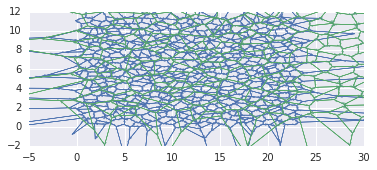

In [128]:
%matplotlib inline
fig, ax = msheet_view(msheet, psi=0, phi=0, theta=np.pi/3, ax=None)
ax.set_xlim(-5, 30)
ax.set_ylim(-2, 12)

In [55]:
from copy import deepcopy
from tyssue.dynamics.sheet_gradients import area_grad
from tyssue.dynamics.base_gradients import length_grad
from tyssue.dynamics.effectors import elastic_force, elastic_energy
from tyssue.utils.utils import _to_3d

class MultiSheetModel(SheetModel):
    
    @staticmethod
    def dimentionalize(mod_specs):
        """
        Changes the values of the input gamma and lambda parameters
        from the values of the prefered height and area.
        Computes the norm factor.
        """

        dim_mod_specs = deepcopy(mod_specs)

        Kv = dim_mod_specs['face']['area_elasticity']
        A0 = dim_mod_specs['face']['prefered_area']
        gamma = dim_mod_specs['face']['contractility']
        kappa_d = dim_mod_specs['vert']['d_elasticity']
        
        dim_mod_specs['face']['contractility'] = gamma * Kv * A0

        lbda = dim_mod_specs['edge']['line_tension']
        dim_mod_specs['edge']['line_tension'] = lbda * Kv * A0**1.5

        dim_mod_specs['settings']['grad_norm_factor'] = Kv * A0**1.5
        dim_mod_specs['settings']['nrj_norm_factor'] = Kv * A0**2

        dim_mod_specs['vert']['d_elasticity'] = kappa_d * Kv * A0
        
        if 'anchor_tension' in dim_mod_specs['edge']:
            t_a = dim_mod_specs['edge']['anchor_tension']
            dim_mod_specs['edge']['anchor_tension'] = t_a * Kv * A0**1.5

        
            
        return dim_mod_specs

    @classmethod
    def compute_energy(cls, msheet, full_output=False):
        
        E = 0
        for sheet in msheet:
            E += PlanarModel.compute_energy(sheet)
        E += cls.desmosome_energy(msheet)
        
        
    @staticmethod
    def desmosome_energy(msheet):
        
        base_sheet = msheet[0]        
        norm_factor = base_sheet.specs['settings']['nrj_norm_factor']
        basal = base_sheet.vert_df.eval(
            '0.5 * d_elasticity * ((z - basal_shift) - prefered_height)**2')
        E_d = basal.sum()/norm_factor
        
        for sheet in msheet[1:]:
            norm_factor = sheet.specs['settings']['nrj_norm_factor']
            upward = sheet.vert_df.eval(
                '0.5 * d_elasticity * (height - prefered_height)**2')
            E_d += upward.sum()/norm_factor
            
        for sheet in msheet[:-1]:
            norm_factor = sheet.specs['settings']['nrj_norm_factor']
            downward = sheet.vert_df.eval(
                '0.5 * d_elasticity * (depth - prefered_height)**2')
            E_d += downward.sum()/norm_factor
        
        return E_d
    
    @classmethod
    def compute_gradient(cls, msheet, components=False):
        
        grads = [pd.DataFrame(0.0, index=sheet.vert_df.index,
                              columns=sheet.coords)
                 for sheet in msheet]
        
        for sheet, (i, grad) in zip(msheet, enumerate(grads)):
            norm_factor = sheet.specs['settings']['nrj_norm_factor']

            grad_lij = length_grad(sheet)
            grad_t = PlanarModel.tension_grad(sheet, grad_lij)
            grad_c = PlanarModel.contractile_grad(sheet, grad_lij)
            grad_a_srce, grad_a_trgt = cls.elastic_grad(sheet)
            grad_i = ((sheet.sum_srce(grad_t) - sheet.sum_trgt(grad_t))/2 +
                      sheet.sum_srce(grad_c) - sheet.sum_trgt(grad_c) +
                      sheet.sum_srce(grad_a_srce) + sheet.sum_trgt(grad_a_trgt))
            grad += grad_i
            grads[i] = grad/norm_factor
        
        return grads
            
    @staticmethod
    def desmosome_gradient(msheet, grads):
        
        base_sheet = msheet[0]
        grads[0]['z'] += base_sheet.vert_df.eval(
            'd_elasticity * ((z - basal_shift) - prefered_height)')
        
        for i, sheet in enumerate(msheet[1:]):
            norm_factor = sheet.specs['settings']['nrj_norm_factor']
            upward = sheet.vert_df.eval(
                'd_elasticity * (height - prefered_height)**2')
            grads[i+1]['z'] += upward/norm_factor
            
        for sheet in msheet[:-1]:
            norm_factor = sheet.specs['settings']['nrj_norm_factor']
            downward = sheet.vert_df.eval(
                'd_elasticity * (prefered_height - depth)**2')
            grads[i]['z'] += downward/norm_factor
        # return grads
    
    @staticmethod
    def elastic_grad(sheet):
        ''' Computes
        :math:`\nabla_i \left(K (A_\alpha - A_0)^2\right)`:
        '''
        coords = sheet.coords

        # volumic elastic force
        # this is K * (A - A0)
        ka_a0_ = elastic_force(sheet.face_df,
                               var='area',
                               elasticity='area_elasticity',
                               prefered='prefered_area')

        ka_a0_ = ka_a0_ * sheet.face_df['is_alive']
        if len(coords) == 2:
            ka_a0 = _to_2d(sheet.upcast_face(ka_a0_))
        elif len(coords) == 3:
            ka_a0 = _to_3d(sheet.upcast_face(ka_a0_))
        grad_a_srce, grad_a_trgt = area_grad(sheet)
        grad_a_srce = ka_a0 * grad_a_srce
        grad_a_trgt = ka_a0 * grad_a_trgt

        return grad_a_srce, grad_a_trgt
        
        
    

In [56]:
mod_specs = {
    'edge': {
        'anchor_tension': 0.12,
        'line_tension': 0.12
        },
     'face': {
        'contractility': 0.04,
        'prefered_area': 1.0,
        'prefered_vol': 0.0,
        'area_elasticity': 1.0
        },
     'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0
        },
     'vert': {
        'radial_tension': 0.0,
        'prefered_height': 1.0,
        'd_elasticity': 1.0}
        }


layers_mod_specs = [
    {'face': {'prefered_area': 1.}},
    {'face': {'prefered_area': 4.}}]

for sheet, spec in zip(msheet, 
                       layers_mod_specs):
    
    spec_updater(mod_specs, spec)
    sheet.update_specs(MultiSheetModel.dimentionalize(mod_specs),
                       reset=True)


In [57]:
MultiSheetModel.compute_energy(msheet)

In [58]:
grad = MultiSheetModel.compute_gradient(msheet)

In [66]:
from scipy import optimize
from tyssue.solvers.sheet_vertex_solver import Solver

class MultiSheetSolver(Solver):
    
    @classmethod
    def find_energy_min(cls, msheet, geom,
                        model, pos_idxs, **settings_kw):
        settings = tyssue.config.solvers.minimize_spec()
        settings.update(**settings_kw)
        
        pos0 = [sheet.vert_df.loc[pos_idx, sheet.coords].values.flatten()
                for sheet, pos_idx in zip(msheet, pos_idxs)]
        
        
        pos0 = np.concatenate(pos0)

        res = optimize.minimize(cls.opt_energy, pos0,
                        args=(pos_idxs, msheet, geom, model),
                        jac=cls.opt_grad,
                        **settings['minimize'])

        
        
    @staticmethod 
    def set_pos(pos, pos_idxs, msheet):
        print('yep')
        v_idxs = np.array([pos_idx.shape[0] for 
                           pos_idx in pos_idxs]).cumsum()
        for sheet, pos_chunk, pos_idx in zip(msheet, np.split(pos, v_idxs[:-1]*3), pos_idxs):
            sheet.vert_df.loc[pos_idx, sheet.coords] = pos_chunk.reshape((pos_chunk.size//3, 3))
            
    @staticmethod
    def opt_grad(pos, pos_idxs, sheet, geom, model):
        grads = model.compute_gradient(sheet, components=False)
        grad_i = np.concatenate([grad.loc[pos_idx].values.flatten()
                                 for grad, pos_idx
                                 in zip(grads, pos_idxs)])
        return grad_i


In [67]:
pos_idxs = [sheet.vert_df[sheet.vert_df['is_active']==1].index
            for sheet in msheet]
MultiSheetSolver.find_energy_min(msheet, MultiSheetGeometry,
                                 MultiSheetModel, pos_idxs)

yep


TypeError: _lbfgsb.setulb() 6th argument (f) can't be converted to double

In [31]:
sheet.vert_df[sheet.coords].flatten()

AttributeError: 'DataFrame' object has no attribute 'flatten'

In [133]:
grp_sheet = Sheet('grped', msheet.concat_datasets(), msheet[0].specs)

In [135]:
vp_view(grp_sheet)